In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (5,2.5)
plt.rcParams["figure.dpi"] = 300

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning,DeprecationWarning))

In [2]:
# simulate one half-period of an underwater pendulum
@np.vectorize
def simulate(sg,l,g,theta0,d,rho,mu):
    theta, dot_theta, t, dt = abs(theta0), -1e-4, 0, 1e-3*2*np.pi*np.sqrt(l/g)
    A,V = np.pi/4*d**2,0.524*d**3
    T,I = (sg-1)*rho*V*g*l,(sg+0.5)*rho*V*l**2+sg*rho*V*d**2/10
    def cd(Re): return max(24./Re, 0.5 if Re<1e5 else 0.25)
    def b(u): return 0.5*rho*A*cd(rho*u*l/mu)*u*l
    while dot_theta <= -1e-4:           # stop when pendulum reverses
        u = max(-dot_theta*l,1e-3)
        ddot_theta = (-b(u)*dot_theta-T*np.sin(theta))/I
        t += dt                             # update time
        theta += dt*dot_theta               # update angle
        dot_theta += dt*ddot_theta          # update velocity
    return np.pi/t                  # return frequency

# set up N experiments
N = 1000; np.random.seed(100)
sg = 2.7+(19.3-2.7)*np.random.random(N) # aluminum to gold
l = 0.5+np.random.random(N)             # 50..150 cm rod
planets = [3.61,8.83,9.81,3.75,26.0,11.2,10.5,13.3]
g = np.random.choice(planets,N)         # pick a planet
theta0 = np.pi*(np.random.random(N)-0.5) # -2..2 radians
d = 0.005+0.045*np.random.random(N)      # 5..25 mm ball
f = np.random.random(N)                 # water/glycerol fraction
rho,mu = 1000+265*f,0.001+3*f
mass = 0.524*sg*rho*d**3

# run
omega = simulate(sg,l,g,theta0,d,rho,mu)

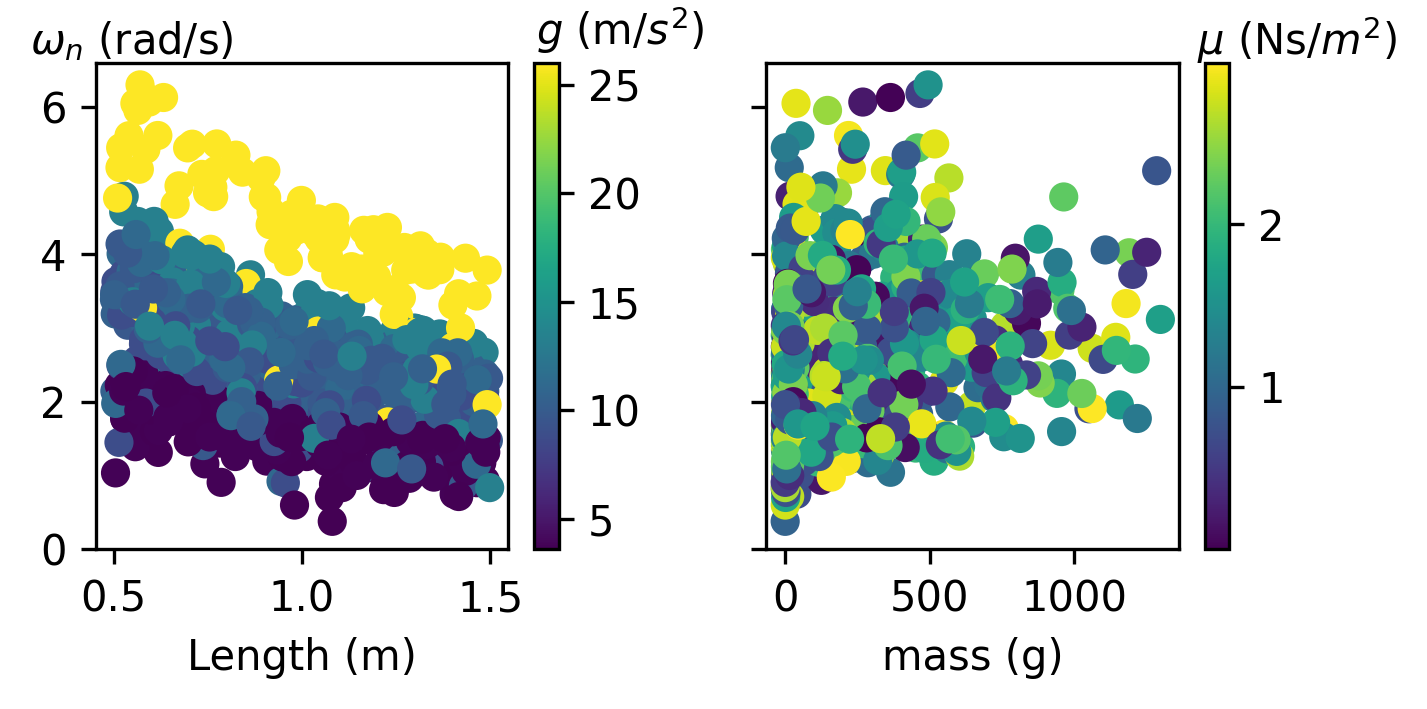

In [3]:
fig, ax = plt.subplots(1,2,sharey=True)
scatter0 = ax[0].scatter(l,omega,c=g)
fig.colorbar(scatter0, ax=ax[0]).set_label('$g$ (m/$s^2$)',rotation=0,y=1.12,labelpad=-5)
ax[0].set_ylabel(r'$\omega_n$ (rad/s)',rotation=0,labelpad=-22,y=1); ax[0].set_ylim(0,)
ax[0].set_xlabel('Length (m)')

scatter1 = ax[1].scatter(1000*mass,omega,c=mu)
fig.colorbar(scatter1, ax=ax[1]).set_label('$\mu$ (Ns/$m^2$)',rotation=0,y=1.1,labelpad=3)
ax[1].set_xlabel("mass (g)")
plt.tight_layout()
plt.savefig('pendulum_bad_scaling.png')

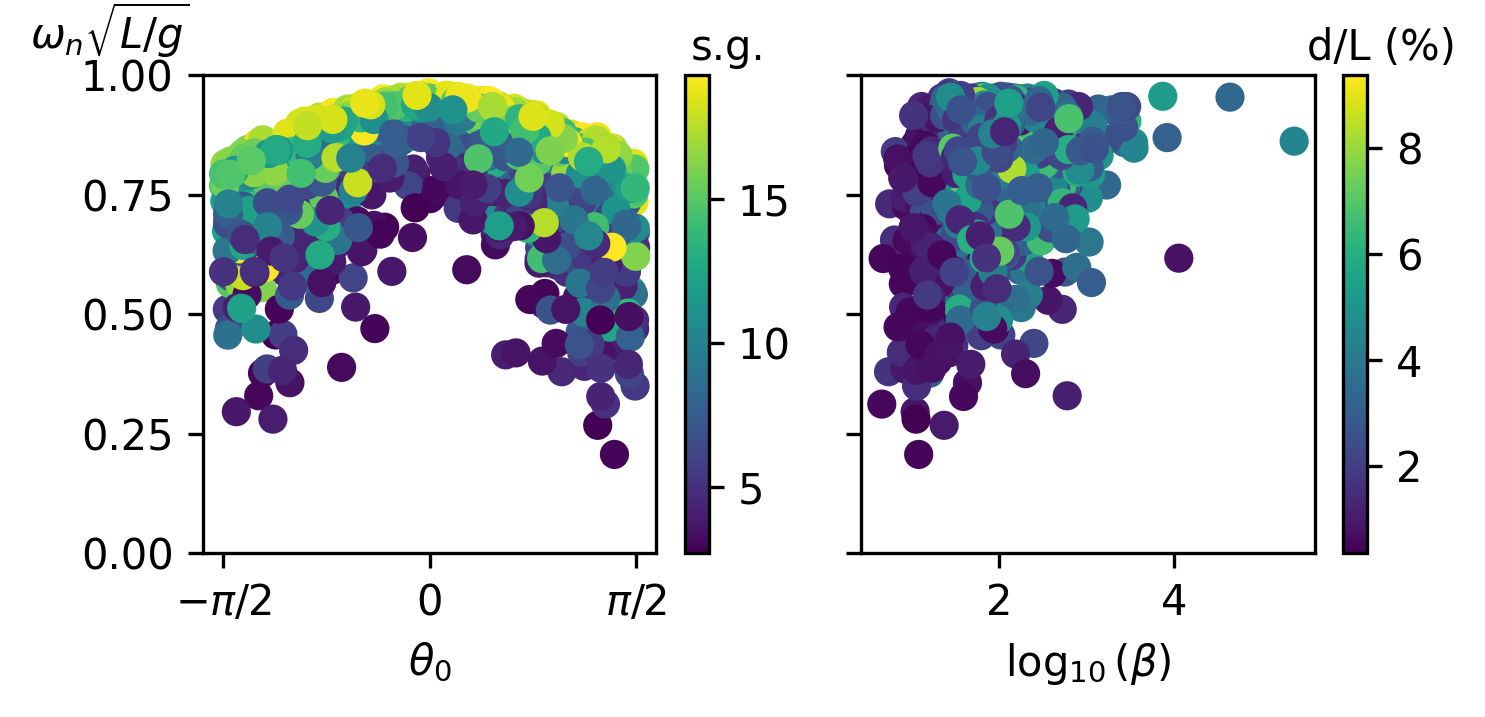

In [4]:
fig, ax = plt.subplots(1,2,sharey=True)
scatter0 = ax[0].scatter(theta0,omega*np.sqrt(l/g),c=sg)
fig.colorbar(scatter0, ax=ax[0]).set_label('s.g.',rotation=0,y=1.1,labelpad=-15)
ax[0].set_ylabel(r'$\omega_n \sqrt{L/g}$',rotation=0, y=1.03, labelpad=-7); ax[0].set_ylim(0,)
ax[0].set_xlabel(r'$\theta_0$'); ax[0].set_xticks([-3.14/2,0,3.14/2]); ax[0].set_xticklabels(['$-\pi/2$',0,'$\pi/2$'])

beta = np.log10(rho*d*np.sqrt(l*g)/mu)
scatter1 = ax[1].scatter(beta,omega*np.sqrt(l/g),c=100*d/l)
fig.colorbar(scatter1, ax=ax[1]).set_label('d/L (%)',rotation=0,y=1.1,labelpad=-10)
ax[1].set_xlabel(r'$\log_{10}(\beta)$')
plt.tight_layout()
plt.savefig('pendulum_better_scaling.png')

In [25]:
# Define data set
X = pd.DataFrame({x:eval(x) for x in ['theta0','mass','l','g','d','rho','mu']})
y = omega

# split -> fit -> test
from sklearn.model_selection import train_test_split
def subfit(n,model,state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n, random_state=state)
    model.fit(X_train, y_train)
    return {'score':model.score(X_test, y_test),'n':n,'state':state}

# loop through the data set sizes
def evaluate(model):
    return pd.DataFrame([subfit(n,model,state)
                         for n in np.logspace(1,2.8,20).astype(int)
                         for state in range(20)])

In [26]:
import math
from typing import List, Type

import numpy as np
import torch
from sklearn.base import BaseEstimator, RegressorMixin
from torch.autograd import Variable
from torch.nn.modules.loss import _Loss
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset

from dataclasses import dataclass, field
from typing import List, Protocol

import torch


@dataclass
class History:
    train_loss: List[float] = field(default_factory=list)
    valid_loss: List[float] = field(default_factory=list)
    epoch_avg_train_loss: List[float] = field(default_factory=list)
    epoch_avg_valid_loss: List[float] = field(default_factory=list)


class Callback(Protocol):
    def call(self, model: torch.nn.Sequential, history: History):
        raise NotImplementedError()

    def finish(self):
        raise NotImplementedError()
    
    def reset(self):
        raise NotImplementedError()

        
class EarlyStopping(Callback):
    def __init__(self, patience: int = 7, verbose: bool = False, delta: float = 0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta

        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.best_state_dict = None

    def __call__(self, model, history: History):
        last_score = -history.epoch_avg_train_loss[-1]

        if self.best_score is None:
            self.best_score = last_score
            self.save_checkpoint(last_score, model)
        elif last_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = last_score
            self.save_checkpoint(last_score, model)
            self.counter = 0

    def call(self, model, history: History):
        self.__call__(model, history)

    # TODO better typing, doesnt have to be torch.nn.Sequential?
    def save_checkpoint(self, val_loss: float, model: torch.nn.Sequential):
        self.best_state_dict = model.state_dict()
        self.val_loss_min = val_loss
    
    def reset(self):
        self.early_stop = False
        self.counter = 0
        self.best_score = None
        self.val_loss_min = np.Inf
        self.best_state_dict = None

    @property
    def finish(self):
        return self.early_stop


def train_valid_loaders(feature_set, test_size=0.2, valid_size=0.2, batch_size=10):
    num_test = int(len(feature_set) * test_size)
    num_train = len(feature_set) - num_test
    train_set, test_set = torch.utils.data.random_split(feature_set, [num_train, num_test])
    num_train = len(train_set)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=0)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler, num_workers=0)

    return train_loader, valid_loader



class PytorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        *,
        hidden_layer_dims: List[int],
        loss_func: _Loss = None,
        activation: Type[Module] = torch.nn.ReLU,
        num_epochs: int = 2000,
        learning_rate: float = 1e-3,
        batch_size: int = 128,
        valid_size: float = 0.2,
        shuffle: bool = False,
        early_stopping: EarlyStopping = None,
        use_gpu: bool = True,
    ):
        """
        A class that can be passed into a Sklearn pipeline for simple regression using a NN with a PyTorch backend.

        :param hidden_layer_dims: Dimensions of the neural network.
        :param loss_func: Loss function to train on. Defaults to MSE.
        :param activation: Activation function of the layers of the NN. Defaults to ReLU.
        :param num_epochs: Maximum number of epochs to train on.
        :param learning_rate: Learning rate for optimiser.
        :param batch_size: Batch size for training.
        :param valid_size: Percentage of data held for validation.
        :param shuffle: Whether to shuffle.
        :param early_stopping: Early stopping class. If not passed, the NN trains to the maximum number of epochs.
        :param use_gpu: Whether to use the GPU, if available.
        """
        self.hidden_layer_dims = hidden_layer_dims
        self.loss_func = loss_func if loss_func else torch.nn.MSELoss()
        self.activation = activation
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.valid_size = valid_size
        self.shuffle = shuffle
        self.early_stopping = early_stopping
        self.use_gpu = use_gpu

        callbacks = []
        if early_stopping:
            callbacks.append(early_stopping)
        self._callbacks = callbacks
        self._history = None
        self._model = None
        self._gpu = use_gpu and torch.cuda.is_available()

    def _build_model(self, input_dim, output_dim):
        self._layer_dims = [input_dim] + self.hidden_layer_dims + [output_dim]

        self._model: torch.nn.Sequential = torch.nn.Sequential()

        for idx, dim in enumerate(self._layer_dims):
            if idx < len(self._layer_dims) - 1:
                module = torch.nn.Linear(dim, self._layer_dims[idx + 1])
                torch.nn.init.xavier_uniform_(module.weight)
                self._model.add_module("linear" + str(idx), module)

            if idx < len(self._layer_dims) - 2:
                self._model.add_module(self.activation.__class__.__name__ + str(idx), self.activation())

        if self._gpu:
            self._model = self._model.cuda()

    def _train_model(self, X: np.ndarray, y: np.ndarray):
        torch_x = torch.from_numpy(X).float()
        torch_y = torch.from_numpy(y).float()
        if self._gpu:
            torch_x = torch_x.cuda()
            torch_y = torch_y.cuda()

        train = TensorDataset(torch_x, torch_y)

        train_loader, valid_loader = train_valid_loaders(train, batch_size=self.batch_size)

        optimizer = torch.optim.Adam(self._model.parameters(), lr=self.learning_rate)

        self._history = History()
        finish = False
        for epoch in range(self.num_epochs):
            if finish:
                print(f"Finishing early: {epoch}/{self.num_epochs}")
                break
            self._model.train()

            epoch_train_losses = []

            for batch, (data, target) in enumerate(train_loader, 1):
                y_pred = self._model(data)

                loss = self.loss_func(y_pred, target.reshape(-1, 1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                self._history.train_loss.append(loss.item())
                epoch_train_losses.append(loss.item())

            epoch_valid_losses = []

            self._model.eval()
            for data, target in valid_loader:
                y_pred = self._model(data)
                loss = self.loss_func(y_pred, target.reshape(-1, 1))
                self._history.valid_loss.append(loss.item())
                epoch_valid_losses.append(loss.item())

            self._history.epoch_avg_train_loss.append(np.average(epoch_train_losses))
            self._history.epoch_avg_valid_loss.append(np.average(epoch_valid_losses))

            for callback in self._callbacks:
                callback.call(self._model, self._history)
                if callback.finish:
                    finish = True
                    break
            

        if self.early_stopping:
            self._model.load_state_dict(self.early_stopping.best_state_dict)
        
        for callback in self._callbacks:
            callback.reset()

    def fit(self, X: np.ndarray, y: np.ndarray):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.DataFrame):
            y = y.values
        input_dim = X.shape[-1]
        output_dim = y.shape[-1] if len(y.shape) > 1 else 1

        assert type(input_dim) == int, "input_dim parameter must be defined"
        assert type(output_dim) == int, "output_dim must be defined"

        self._build_model(input_dim, output_dim)
        self._train_model(X, y)

        return self

    def predict(self, X: np.ndarray):
        if isinstance(X, pd.DataFrame):
            X = X.values
        results = []
        split_size = math.ceil(len(X) / self.batch_size)
        for batch in np.array_split(X, split_size):
            x_pred = Variable(torch.from_numpy(batch).float())
            y_pred = self._model(x_pred.cuda() if self._gpu else x_pred).float()
            y_pred_formatted = y_pred.cpu().data.numpy() if self._gpu else y_pred.data.numpy()
            results = np.append(results, y_pred_formatted)
        return results

    def score(self, X: np.ndarray, y: np.ndarray, sample_weight=None):
        X = torch.from_numpy(X).cuda().float()
        y_pred = self._model(X)
        y = torch.from_numpy(y).cuda().float()
        return self.loss_func(y_pred, y).item()

In [7]:
model = PytorchRegressor(hidden_layer_dims=[12, 8, 6], early_stopping=EarlyStopping(patience=100))

In [155]:
nn_performance = evaluate(model)

Finishing early: 118/2000
Finishing early: 210/2000
Finishing early: 172/2000
Finishing early: 160/2000
Finishing early: 126/2000
Finishing early: 216/2000
Finishing early: 120/2000
Finishing early: 135/2000
Finishing early: 125/2000
Finishing early: 102/2000
Finishing early: 111/2000
Finishing early: 119/2000
Finishing early: 120/2000
Finishing early: 406/2000
Finishing early: 202/2000
Finishing early: 515/2000
Finishing early: 448/2000
Finishing early: 371/2000
Finishing early: 379/2000
Finishing early: 290/2000
Finishing early: 217/2000
Finishing early: 233/2000
Finishing early: 207/2000
Finishing early: 302/2000
Finishing early: 339/2000
Finishing early: 254/2000
Finishing early: 194/2000
Finishing early: 727/2000
Finishing early: 259/2000
Finishing early: 158/2000
Finishing early: 627/2000
Finishing early: 299/2000
Finishing early: 307/2000
Finishing early: 212/2000
Finishing early: 697/2000
Finishing early: 220/2000
Finishing early: 233/2000
Finishing early: 236/2000
Finishing ea

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.base import RegressorMixin, clone


class feature_map(RegressorMixin):
    def __init__(self,model,phi=lambda X:X,psi=lambda X,y:y,apsi=lambda X,y:y):
        self.model,self.phi,self.psi,self.apsi = model,phi,psi,apsi
        
    def fit(self, X=None, y=None):
        self.model.fit(self.phi(X),self.psi(X,y))

    def predict(self, X=None):
        return self.apsi(X,self.model.predict(self.phi(X)))

# Buckingham Pi mapping
def phi(X): 
    return pd.DataFrame({'theta0':X.theta0,'sg':X.mass/(X.rho*X.d**3)})
def psi(X,y): return y*np.sqrt(X.l/X.g).values
def apsi(X,y): return y/np.sqrt(X.l/X.g).values
    
model = PytorchRegressor(hidden_layer_dims=[12, 8, 6], early_stopping=EarlyStopping(patience=100))
phi_model = feature_map(model, phi, psi, apsi)

In [28]:
phi_results = evaluate(phi_model)

Finishing early: 1521/2000
Finishing early: 1044/2000
Finishing early: 1630/2000
Finishing early: 1644/2000
Finishing early: 1698/2000
Finishing early: 1958/2000
Finishing early: 1950/2000
Finishing early: 931/2000
Finishing early: 398/2000
Finishing early: 1152/2000
Finishing early: 527/2000
Finishing early: 708/2000
Finishing early: 333/2000
Finishing early: 382/2000
Finishing early: 356/2000
Finishing early: 683/2000
Finishing early: 837/2000
Finishing early: 543/2000
Finishing early: 450/2000
Finishing early: 205/2000
Finishing early: 441/2000
Finishing early: 1081/2000
Finishing early: 954/2000
Finishing early: 548/2000
Finishing early: 1328/2000
Finishing early: 482/2000
Finishing early: 996/2000
Finishing early: 642/2000
Finishing early: 580/2000
Finishing early: 657/2000
Finishing early: 382/2000
Finishing early: 236/2000
Finishing early: 603/2000
Finishing early: 559/2000
Finishing early: 464/2000
Finishing early: 563/2000
Finishing early: 558/2000
Finishing early: 853/2000
Fi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


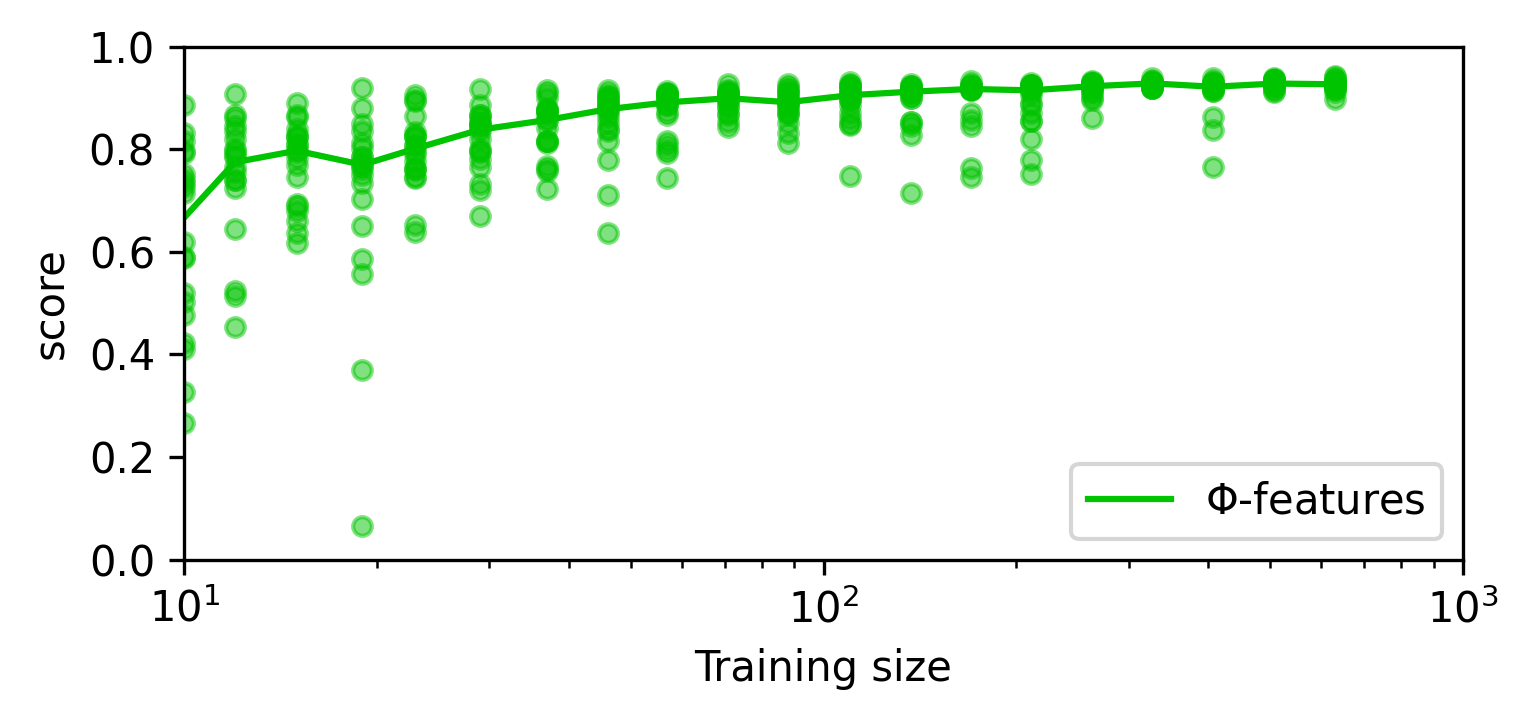

In [31]:
fig,ax = plt.subplots()

plt.ylim(0,1)
plt.xscale('log'); plt.xlim(10,1e3)
plt.legend()
plt.xlabel('Training size N')
plt.tight_layout()
plt.savefig('pendulum_LS.png')

green = '#00c400'
phi_results.plot.scatter(x='n',y='score',ax=ax,c=green,alpha=0.5)
phi_results.groupby('n').median().reset_index().plot(x='n',y='score',ax=ax,c=green,label='$\Phi$-features')
plt.xlabel('Training size')
plt.savefig('pendulum_Pi.png')

In [37]:
phi_model.model.save

AttributeError: 'PytorchRegressor' object has no attribute 'save'